# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [2]:
!pip install mmcv

     |################################| 51kB 593kB/s eta 0:00:011
     |################################| 2.1MB 2.1MB/s eta 0:00:01
  Created wheel for mmcv: filename=mmcv-0.2.14-cp36-cp36m-linux_x86_64.whl size=157022 sha256=c9f2f1b202b7bf37870eb803c9575f1282b8d8f23e34c6fe8424c2a9f7fd020d
  Stored in directory: /root/.cache/pip/wheels/46/30/a2/b2c6819a7bd47554b8c65c3210181611f32fcccb0f97b607dc
Successfully built mmcv


In [1]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
torch.cuda.current_device()

0

#### Define MTCNN module

Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [95]:
mtcnn = MTCNN(keep_all=True, device=device, thresholds=[0.9, 0.9, 0.9])

In [96]:
import glob

img = glob.glob('../test_image/'+'*.jpg')
img

['../test_image/2.jpg',
 '../test_image/4.jpg',
 '../test_image/1.jpg',
 '../test_image/3.jpg']

In [97]:
from PIL import Image

im = Image.open(img[0])

In [98]:
boxes, _ = mtcnn.detect(im)

In [99]:
len(boxes)

5

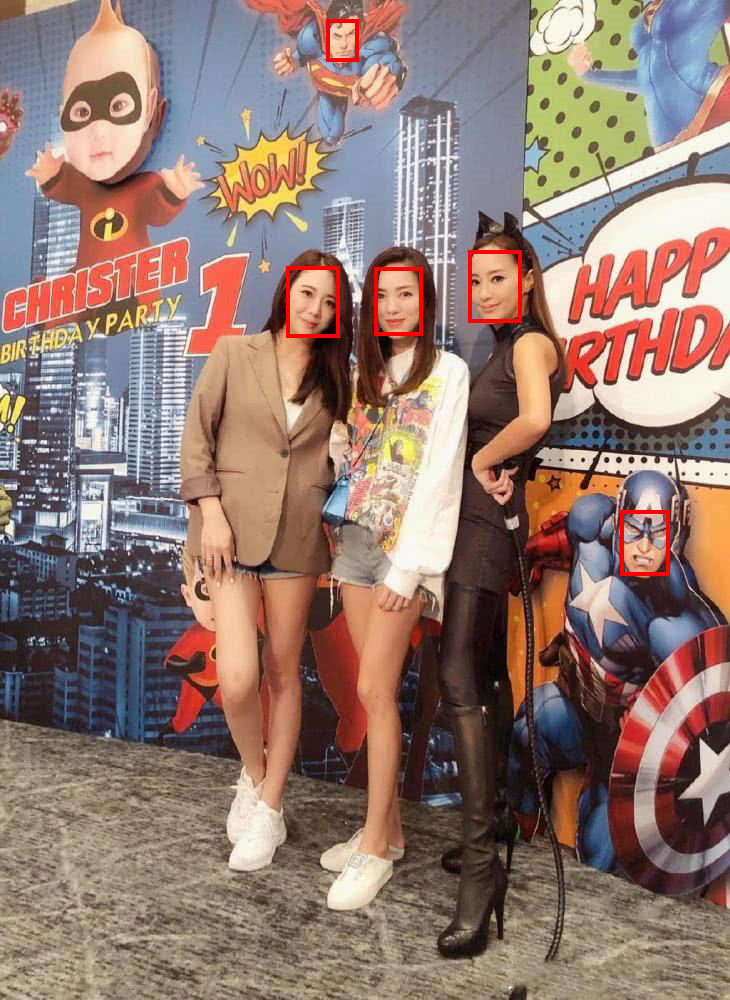

In [100]:
# Draw faces
frame_draw = im.copy()
draw = ImageDraw.Draw(frame_draw)
for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=4)
    
display.display(frame_draw)

#### Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [8]:
video = mmcv.VideoReader('video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('video.mp4', width=640)

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [9]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 105
Done


#### Display detections

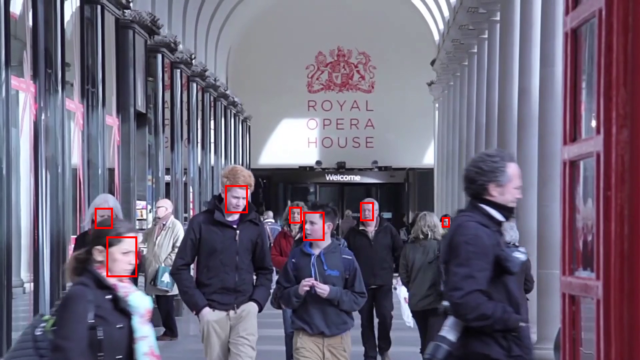

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

#### Save tracked video

In [ ]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()